# ERA5 Lazy Loading via CDS Store

Some experiments.

In [1]:
import cdsapi
import fsspec
import xarray as xr
import dask.array as dsa
from dask.base import tokenize
import pandas as pd
%matplotlib inline

### Demonstrate that we can load data without actually downloading it to a file

Note that this example apparently only works quickly because I am using the exacty request parameters from the [CDS API docs](https://confluence.ecmwf.int/display/CKB/C3S+ERA5%3A+Web+API+to+CDS+API).
If I change any of the parameters (e.g. `'time': '13:00'`), it says `Request is queued` forever.
Is this a bug? What am I doing wrong? I waited over 10 minutes and it still didn't complete.

Nevertheless, it's proof of concept.

In [2]:
c = cdsapi.Client()
name = 'reanalysis-era5-pressure-levels'
request = {
        'year'          : '2008',
        'month'         : '01',
        'day'           : '01',
        'time'          : '12:00',
        'variable'      : 'temperature',
        'pressure_level': '1000',
        'product_type'  : 'reanalysis',
        'format'        : 'netcdf'
    }
r = c.retrieve(name, request, None)

with fsspec.open(r.location) as f:
    ds = xr.open_dataset(f, engine='scipy')
    print(ds)

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:39:59,701 INFO Welcome to the CDS
2019-12-04 23:39:59,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:00,170 INFO Request is completed


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01T12:00:00
Data variables:
    t          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-30 09:59:39 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...


### Define a class to do this lazily for many timesteps

In [3]:
def request_to_dataset(name, request):
    c = cdsapi.Client()
    r = c.retrieve(name, request, None)
    with fsspec.open(r.location) as f:
        ds = xr.open_dataset(f, engine='scipy')
    return ds


def request_to_numpy_array(name, request, vname):
    ds = request_to_dataset(name, request)
    return ds[vname].values


def full_request(request_base, date):
    request = {'year': f'{date.year}',
               'month': f'{date.month:02d}',
               'day': f'{date.day:02d}',
               'time': f'{date.hour:02d}:00'}
    request.update(request_base)
    return request

    
class CDSTimeseriesRequest:
    """A class that can generate lazy representations of CDS data for many timesteps.
    
    Parameters
    ----------
    name : str
        Passed to CDS API
    request_base : dict
        Passed to CDS API
    **date_range_kwargs : dict
        Passed to pandas.date_range to generate dates
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
    """
    
    def __init__(self, name, request_base, **date_range_kwargs):
        self.name = name
        self.request_base = request_base
        # TODO: validate date range
        self.time = pd.date_range(**date_range_kwargs)
        
    
    def dataset(self):
        """Create xarray dataset for requests.
        
        Returns
        -------
        ds : xarray.Dataset
        """
        # get the first file eagerly
        request = full_request(self.request_base, self.time[0])
        ds1 = request_to_dataset(self.name, request)
        
        assert len(ds1.data_vars) == 1
        vname = list(ds1.data_vars.keys())[0]
        dvar = ds1[vname]
        dtype = dvar.dtype
        base_shape = dvar.shape[1:]
        shape = (len(self.time),) + base_shape

        # manually build dask graph
        # this is a bit a black magic, and there are easier ways to do it
        # however, this way scales very well (can handle millions of tasks)
        chunks = (len(self.time) * (1,),) + tuple([(s,) for s in base_shape])
        dsk = {}
        token = tokenize(self.name, self.request_base, self.time)
        for n_time, time in enumerate(self.time):
            request = full_request(self.request_base, time)
            name = '-'.join([vname, token])
            key = (name, n_time) + len(base_shape) * (0,)
            task = request_to_numpy_array, self.name, request, vname
            dsk[key] = task
        data = dsa.Array(dsk, name, chunks, dtype)

        # put back together as a dataset
        coords = ds1.coords
        del coords['time']
        ds = xr.Dataset({vname: (dvar.dims, data, dvar.attrs)},
                        coords=coords)
        ds['time'] = 'time', self.time
        return ds

### Create a Dataset Lazily

Note that the first file has to be loaded eagerly in order to figure out the shape / dtype and generate the coordinates.

In [4]:
name = 'reanalysis-era5-pressure-levels'
request_base = {'variable': 'temperature',
                'pressure_level': '1000',
                'product_type': 'reanalysis',
                'format': 'netcdf'}
r = CDSTimeseriesRequest(name, request_base, start='2008-01-01 12:00', freq='1H', periods=24)
dsc = r.dataset()
dsc

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:03,290 INFO Welcome to the CDS
2019-12-04 23:40:03,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 24)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01T12:00:00 ... 2008-01-02T11:00:00
Data variables:
    t          (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [5]:
dsc.t.data

dask.array<t, shape=(24, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>

### Load first timestep

This one goes fast because it is already cached. (This is the example request from the [CDS API docs](https://confluence.ecmwf.int/display/CKB/C3S+ERA5%3A+Web+API+to+CDS+API).)

In [6]:
dsc.t[0].load()

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:08,594 INFO Welcome to the CDS
2019-12-04 23:40:08,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:09,039 INFO Request is completed
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request

<xarray.DataArray 't' (latitude: 721, longitude: 1440)>
array([[249.14964, 249.14964, 249.14964, ..., 249.14964, 249.14964,
        249.14964],
       [248.88579, 248.88579, 248.88579, ..., 248.88579, 248.88579,
        248.88579],
       [249.04938, 249.04938, 249.04807, ..., 249.05202, 249.05202,
        249.04938],
       ...,
       [260.20926, 260.20926, 260.20926, ..., 260.21188, 260.21188,
        260.20926],
       [260.35965, 260.35965, 260.35965, ..., 260.35834, 260.35834,
        260.35834],
       [260.47574, 260.47574, 260.47574, ..., 260.47574, 260.47574,
        260.47574]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2008-01-01T12:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:12,530 INFO Welcome to the CDS
2019-12-04 23:40:12,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:12,980 INFO Request is completed
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request

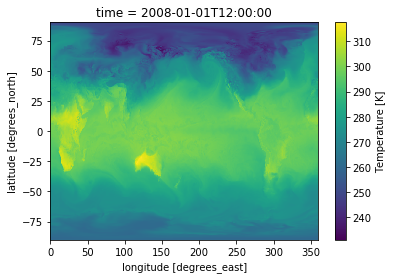

In [7]:
dsc.t[0].plot()

### Load a subsequent timestep

This just seems to hang forever.

In [8]:
dsc.t[1].load()

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:17,975 INFO Welcome to the CDS
2019-12-04 23:40:17,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-12-04 23:40:18,412 INFO Request is queued
/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is

KeyboardInterrupt: 

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
